In [1]:
! pip install syft

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler, Subset

import numpy as np
from syft.frameworks.torch.differential_privacy import pate

W0626 08:15:36.194712 140556153022336 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0-rc1.so'
W0626 08:15:36.211523 140556153022336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
def create_data_loaders (num_training_loaders):

    # Define a transform to normalize the data
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])
    # Download and load the training data
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    # Set up the trainloaders list
    trainloaders = []
    data_per_set = int(len(mnist_trainset) / num_training_loaders)
    for i in range(num_training_loaders):
        train_indices = range(i*data_per_set,i*data_per_set+data_per_set)
        trainloaders.append(torch.utils.data.DataLoader(mnist_trainset, 
                                                         batch_size=32, 
                                                         sampler=SubsetRandomSampler(train_indices)))


    return trainloaders

In [0]:
def create_testloader(noise_labels):
    transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    mnist_test_train = Subset(mnist_testset,range(9000))
    mnist_test_train.targets = noise_labels # replace with the noise labels
    
    mnist_test_test = Subset(mnist_testset,range(9000,10001))
    # Set up the testloader
    # Use for train student model
    testtrainloader = torch.utils.data.DataLoader(mnist_test_train, batch_size=32, shuffle=False)
    testtrain_targets = mnist_testset.test_labels[:9000]

    # Use for evaluate the student model
    testtestloader = torch.utils.data.DataLoader(mnist_test_test, batch_size=1000, shuffle=False)
    testtest_targets = mnist_testset.test_labels[9000:]
    return testtrainloader, testtestloader, testtest_targets

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256) 
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [0]:
def create_models(n) : return [Net() for i in range(n)]

# Train the models

In [0]:
num_teachers = 10
epochs = 10

In [7]:
trainloaders = create_data_loaders(num_teachers)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
models = create_models(num_teachers)
criterion = nn.NLLLoss()

In [0]:
def train(model,dataloader,epochs=4):
    optimizer = optim.Adam(model.parameters(),lr=1e-2)
    for e in range(epochs):
        running_loss = 0
        preds = torch.tensor([])
        for images,labels in dataloader:
            optimizer.zero_grad()
            
            out = model(images)
            pred = torch.argmax(torch.exp(out),dim=1) == labels
            preds = torch.cat([preds,pred.float()])

            loss = criterion(out,labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss
            
        print(f'Epoch : {e} loss : {running_loss/len(dataloader)} acc : {preds.float().mean()*100}')


In [10]:
for i,(model,trainloader)  in enumerate(zip(models,trainloaders)):
    print('-'*20)
    print(f"Model {i}")
    train(model,trainloader,epochs)

--------------------
Model 0
Epoch : 0 loss : 0.6454094648361206 acc : 79.81666564941406
Epoch : 1 loss : 0.35386961698532104 acc : 90.21666717529297
Epoch : 2 loss : 0.32891884446144104 acc : 91.26667022705078
Epoch : 3 loss : 0.25572460889816284 acc : 93.16666412353516
Epoch : 4 loss : 0.20851874351501465 acc : 94.66666412353516
Epoch : 5 loss : 0.20389479398727417 acc : 94.58333587646484
Epoch : 6 loss : 0.191820427775383 acc : 95.31666564941406
Epoch : 7 loss : 0.2108403444290161 acc : 94.48333740234375
Epoch : 8 loss : 0.24871844053268433 acc : 93.86666107177734
Epoch : 9 loss : 0.21632781624794006 acc : 95.05000305175781
--------------------
Model 1
Epoch : 0 loss : 0.6815393567085266 acc : 78.66667175292969
Epoch : 1 loss : 0.3393597900867462 acc : 90.4000015258789
Epoch : 2 loss : 0.28933101892471313 acc : 91.94999694824219
Epoch : 3 loss : 0.3019282817840576 acc : 92.21666717529297
Epoch : 4 loss : 0.2674931585788727 acc : 93.0999984741211
Epoch : 5 loss : 0.2070809006690979 a

# Label test set

In [0]:
def label_data(models,dataloader):
    labels = [[] for i in range(len(models))] # all the labels gonna be computed
    for img, label in dataloader:
        for i, model in enumerate(models):
            out = model(img)
            out = torch.argmax(out,dim=1).tolist()
            labels[i].extend(out) # append to the label of each model
    labels = np.array(labels)
    return labels

In [0]:
labels = label_data(models, testtrainloader) # num_teachers x 9000

In [13]:
labels[:,1]

array([8, 2, 2, 2, 2, 2, 2, 2, 2, 0])

In [0]:
import matplotlib.pyplot as plt

In [0]:
def view(n=5):
    count = 0
    for data ,label in testtrainloader:
        for image, l in zip(data,label):
            if count > n:
                break
            
            plt.imshow(image[0].numpy())
#             plt.title(f"actual: {str(l)} fd: {np.argmax(labels,axis=0)[count]}")
            plt.title(f"actual: {str(l)} fd: {labels[:,count]}")
            plt.show()
            count+=1

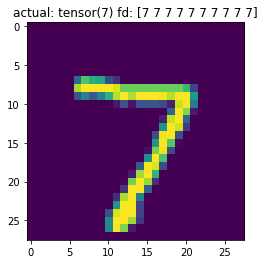

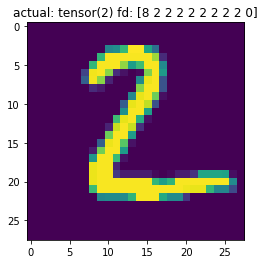

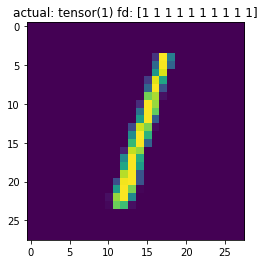

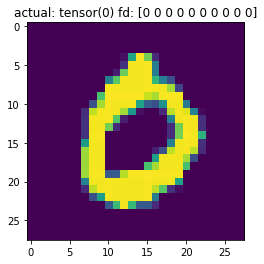

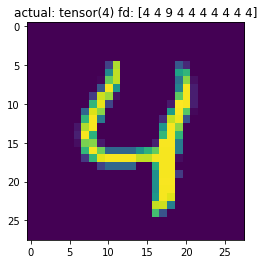

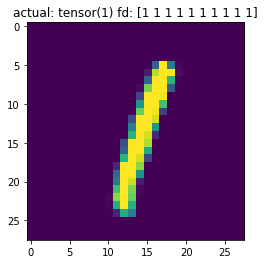

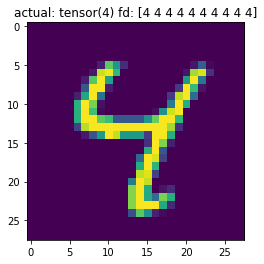

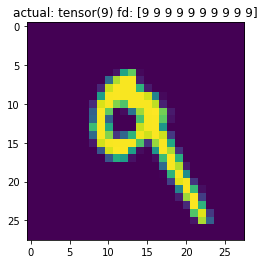

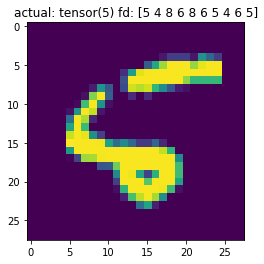

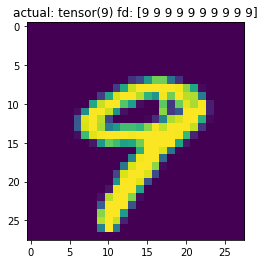

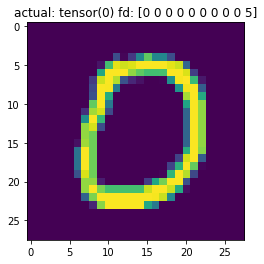

In [34]:
view(10)

In [0]:
def DP(labels,eps):
    assert labels.shape == (num_teachers,9000), "Shape ain't right"
    labels = labels.transpose(1,0) # (10000,10)
    new_labels = []
    beta = 1 / eps
    # loop through samples
    for label in labels:
        # count the num of labels
        label_counts = np.bincount(label, minlength=10).astype(np.float64)
        # add noise
        label_counts += np.random.laplace(0,beta,len(label_counts)) 
        new_label = np.argmax(label_counts)
        new_labels.append(new_label)
        
    new_labels = np.array(new_labels)
    return new_labels



In [0]:
eps = .11

In [0]:
noise_labels = DP(labels,eps)

In [44]:
testtrainloader, testtestloader, testtest_targets = create_testloader(noise_labels)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [20]:
np.mean(noise_labels == testtrain_targets.numpy())

0.264

In [0]:
# data dependant epsilon , data independant epsilon
dep_eps ,indep_deps = pate.perform_analysis(teacher_preds=labels, indices=noise_labels, noise_eps=eps)

In [22]:
dep_eps ,indep_deps

(447.1129254649932, 447.1129254649702)

In [36]:
for e in [.01,.03,.05,.1]:
    noise_labels = DP(labels,e)
    dep_eps ,indep_deps = pate.perform_analysis(teacher_preds=labels,indices=noise_labels,noise_eps=e)
    print(f"With {e} :")
    print(f"data dependent epsilon : {dep_eps}")
    print(f"data independent epsilon : {indep_deps}")
    print('-'*20)

With 0.01 :
data dependent epsilon : 11.037641821657521
data independent epsilon : 11.037641821656743
--------------------
With 0.03 :
data dependent epsilon : 43.91292546496508
data independent epsilon : 43.91292546497023
--------------------
With 0.05 :
data dependent epsilon : 101.51292546497936
data independent epsilon : 101.51292546497024
--------------------
With 0.1 :
data dependent epsilon : 371.5129254650068
data independent epsilon : 371.5129254649703
--------------------


In [0]:
model_test = create_models(1)[0] # create a test model

In [51]:
# train model test train data
train(model_test, testtrainloader, 20)

Epoch : 0 loss : 0.23887509107589722 acc : 96.07777404785156
Epoch : 1 loss : 0.2613787353038788 acc : 95.03333282470703
Epoch : 2 loss : 0.3278201222419739 acc : 94.4888916015625
Epoch : 3 loss : 0.2633119225502014 acc : 94.03333282470703
Epoch : 4 loss : 0.1567252278327942 acc : 96.54444122314453
Epoch : 5 loss : 0.28615862131118774 acc : 94.25555419921875
Epoch : 6 loss : 0.20864488184452057 acc : 95.5
Epoch : 7 loss : 0.2257058024406433 acc : 95.98888397216797
Epoch : 8 loss : 0.21312260627746582 acc : 95.63333129882812
Epoch : 9 loss : 0.2004043161869049 acc : 95.94444274902344


In [52]:
# test on test set
data, label = next(iter(testtestloader))
with torch.no_grad():
    out = model_test(data)
    out = torch.argmax(out,dim=1)
    print('Acc on testset')
    print(np.mean(label.numpy()==out.numpy()))

Acc on testset
0.924


In [0]:
??pate.perform_analysis